In [9]:
import numpy as np 
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import networkx as nx
plt.rcParams.update({'font.size': 15})

# SIR Model
The SIR model is one of the most basic of compartmental models in mathematical epidemiology. The model subdivides a population into three states, susceptible, infected and recovered. There are various extensions to this model which add additional states such as the SIRS model and the SEIR model. The following SIR model is derived from Law of Mass Action dynamics   
\begin{align}
    \frac{dS}{dt} &= -\beta SI \\
    \frac{dI}{dt} &=\beta SI -\gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align}

In [158]:
# Initialise Params
params = dict()
params['beta'] = 0.002      
params['gamma'] = 0.01

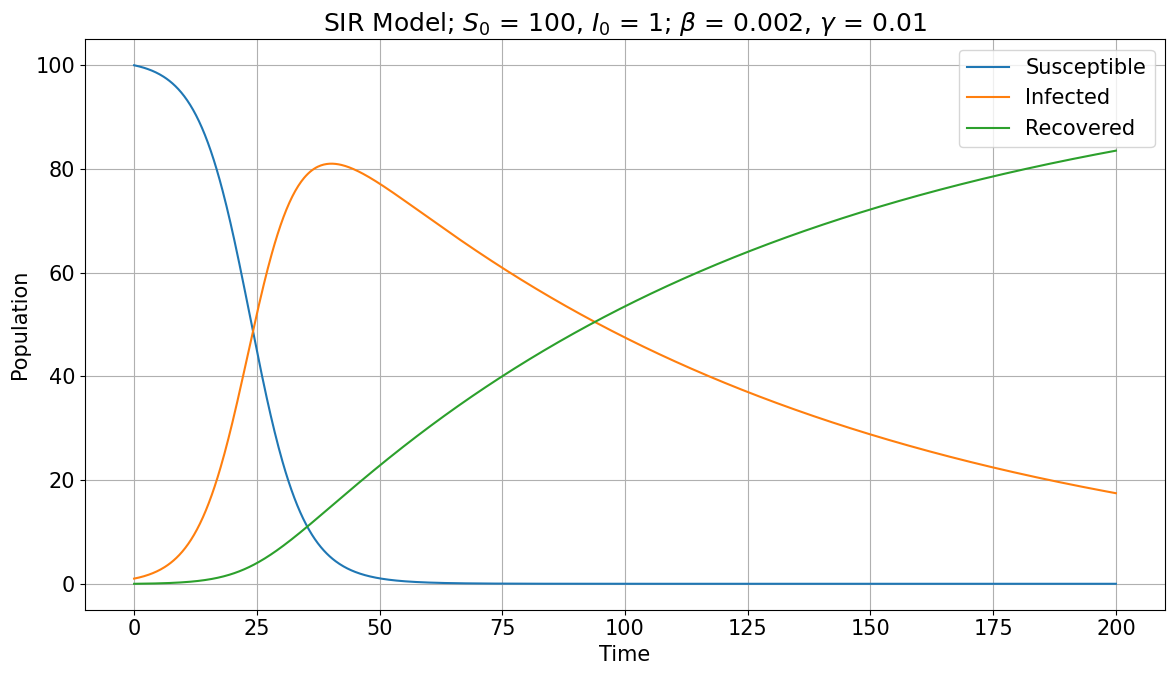

In [159]:
def SIR(x,t,params = params):
    s,i,r = x
    dxdt = [-params['beta']*s*i,
            params['beta']*s*i -params['gamma']*i,
            params['gamma']*i
            ]
    return dxdt

# Initial Condition
x0 = [100,1,0.0]
t = np.linspace(0, 200, 1000)
sol = odeint(SIR, x0, t)
fig, ax = plt.subplots(1,figsize = (12,7))
ax.plot(t, sol[:, 0], label='Susceptible')
ax.plot(t, sol[:, 1], label='Infected')
ax.plot(t, sol[:, 2], label='Recovered')
ax.set_title(f'SIR Model; $S_0$ = {x0[0]}, $I_0$ = {x0[1]}; $\\beta$ = {params["beta"]}, $\gamma$ = {params["gamma"]}')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.grid()
plt.tight_layout()
plt.show()

/var/folders/_m/40jm_4wj5hscmh202vkys0r80000gn/T/ipykernel_37863/105631229.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


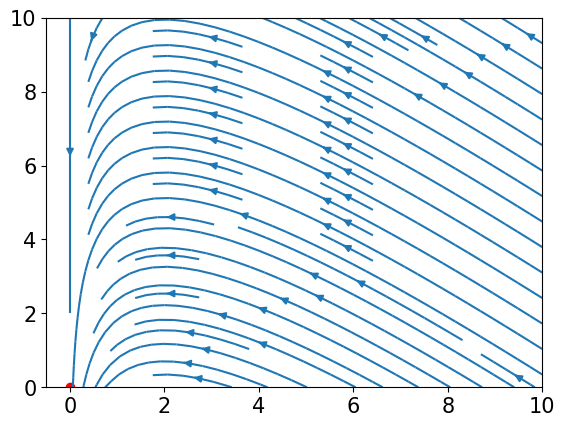

In [4]:
plt.close("all")

fixed_points = np.array([[0.,0.]])

s = np.linspace(0, 10, 10)
i = np.linspace(0, 10, 10)
S, I = np.meshgrid(s, i)

Sdot = -params['beta']*S*I
Idot =  params['beta']*S*I -params['gamma']*I
 

fig, ax = plt.subplots()
ax.streamplot(S, I, Sdot, Idot)
ax.scatter(*fixed_points.T, color="r")
fig.show()

## Network-Based Models
Below are the three network models we consider in the project
### Barabási–Albert Model

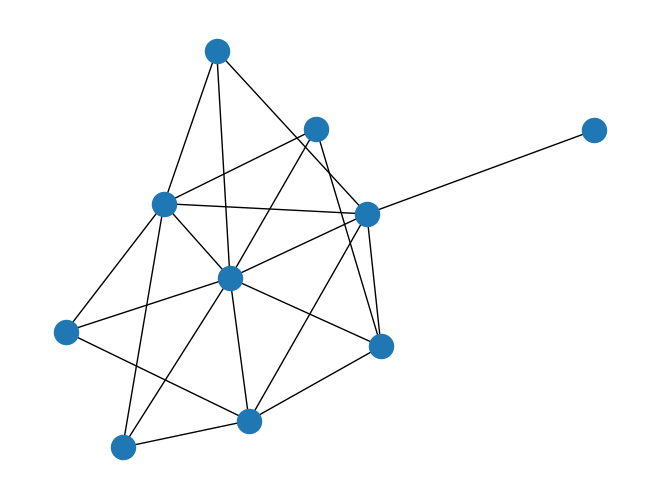

In [ ]:
G = nx.barabasi_albert_graph(10,3)
nx.draw(G)

### Watts-Strogatz Model

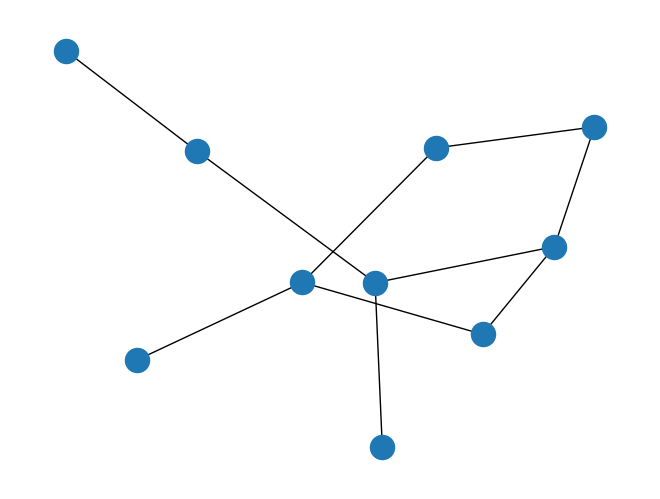

In [18]:
G = nx.watts_strogatz_graph(10,3,0.25)
nx.draw(G)

## Erdös-Rényi Model


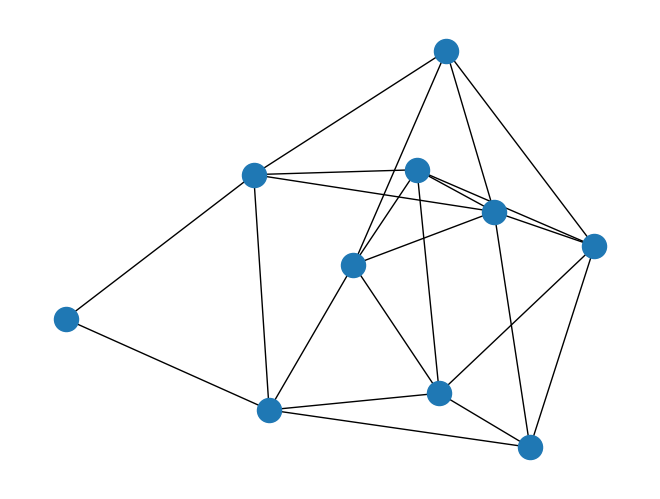

In [21]:
G = nx.erdos_renyi_graph(10,0.5)
nx.draw(G)

## Model 1
Model 1 follows a simple SIR approach outlined by Newman. The parameters are the probability distributions $P(r)$ and $P(\tau)$ and the choice of network model. 

In [ ]:
def model_1(G: nx.Graph, sim_length: int):
    states = {node: ('I', np.random.randint(0, 100)) if node == 0 else ('S', np.random.randint(0, 100)) for node in G}
    T = 0.05  # Infection probability coefficient

    time_series_data = {'S': [0 for i in range(sim_length)],
                        'I': [0 for i in range(sim_length)],
                        'R': [0 for i in range(sim_length)]}
    
    for t in range(sim_length):
        for state in states.items():
            time_series_data[state[1][0]][t]+= 1
            
        new_states = states.copy()  # Store state updates

        for node in G:
            state, tau = states[node]

            if state == 'I':
                if tau > 0:
                    new_states[node] = ('I', tau - 1)
                else:
                    new_states[node] = ('R', tau)  # Recovered

            elif state == 'S':
                infected_neighbours = sum(1 for neighbour in G.neighbors(node) if states[neighbour][0] == 'I')
                
                if np.random.uniform(0, 1) < infected_neighbours * T:
                    new_states[node] = ('I', tau)

        states = new_states  # Update states after processing all nodes

    return states, time_series_data


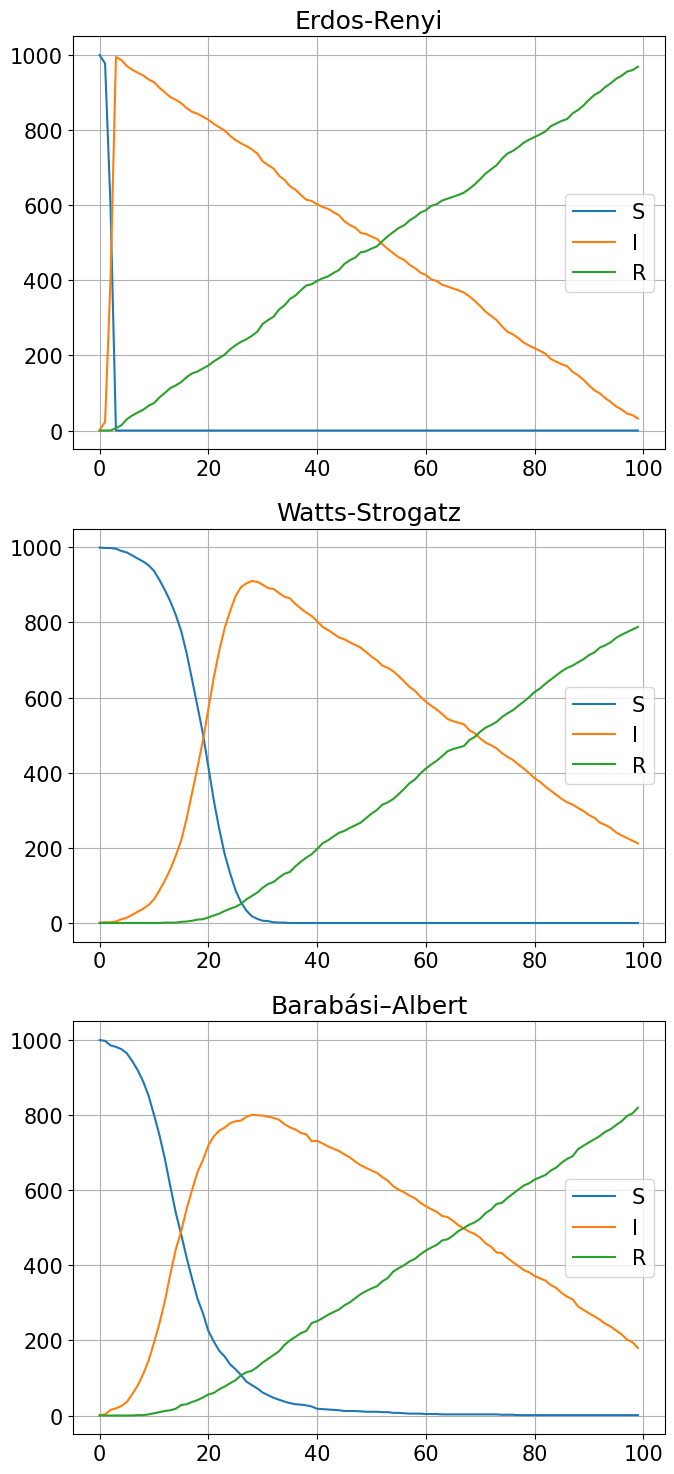

In [221]:
## Params
n = 1000
sim_dur = 100
time = [i for i in range(sim_dur)]

## Networks
ER = nx.erdos_renyi_graph(n,1/3)
WS = nx.watts_strogatz_graph(n,10,0.25) # 10 nearest neighbours, p = 1/4
BA = nx.barabasi_albert_graph(n,3)
meta_dict_1,time_series_data_1 = model_1(ER,sim_dur)
meta_dict_1,time_series_data_2 = model_1(WS,sim_dur)
meta_dict_1,time_series_data_3 = model_1(BA,sim_dur)

# Plots
fig, ax = plt.subplots(3,1, figsize = (7,15))
ax[0].plot(time,time_series_data_1['S'], label = 'S')
ax[0].plot(time,time_series_data_1['I'], label = 'I')
ax[0].plot(time,time_series_data_1['R'], label = 'R')
ax[0].set_title('Erdos-Renyi')
ax[0].legend()
ax[0].grid()

ax[1].plot(time,time_series_data_2['S'], label = 'S')
ax[1].plot(time,time_series_data_2['I'], label = 'I')
ax[1].plot(time,time_series_data_2['R'], label = 'R')
ax[1].set_title('Watts-Strogatz')
ax[1].legend()
ax[1].grid()

ax[2].plot(time,time_series_data_3['S'], label = 'S')
ax[2].plot(time,time_series_data_3['I'], label = 'I')
ax[2].plot(time,time_series_data_3['R'], label = 'R')
ax[2].set_title('Barabási–Albert')
ax[2].legend()
ax[2].grid()
plt.tight_layout()
plt.show()

# SEDPNR model
The SEDPNR model is the following system of linear ODEs
\begin{align}
    \frac{dS}{dt} &= \mu_1 E + \mu_2 D - \alpha S \\
    \frac{dE}{dt} &= \alpha S - (\beta_1 + \beta_2 + \gamma + \mu_1)E \\
    \frac{dD}{dt} &= \gamma E - (\beta_3 + \beta_4 + \mu_2)D \\
    \frac{dP}{dt} &= \beta_1 E + \beta_3 D - \delta_1 P \\
    \frac{dN}{dt} &= \beta_2 E + \beta_4 D - \delta_2 N \\
    \frac{dR}{dt} &= \delta_1 P + \delta_2 N
\end{align}
which models the spread of misinformation through a population. This notebook will explore some numerical analysis of this model.

In [5]:
# Initialise Params
params = dict()
params['mu_1'] = 1
params['mu_2'] = 1
params['beta_1'] = 0.4      # probability; transition from the Exposed state to the Doubter state
params['beta_2'] = 0.5      # probability; transition from the Exposed state to the Infected state
params['beta_3'] = 1        # Doubter to positively infected
params['beta_4'] = 1      # Doubter to negatively infected
params['alpha'] = 1         # Transition rate between susceptible to exposed 
params['gamma'] = 1         # Transition rate from exposed to doubter
params['delta_1'] = 0.1    # Positively infected state to the Restrained state
params['delta_2'] = 0.01   # Negatively infected state to the Restrained state

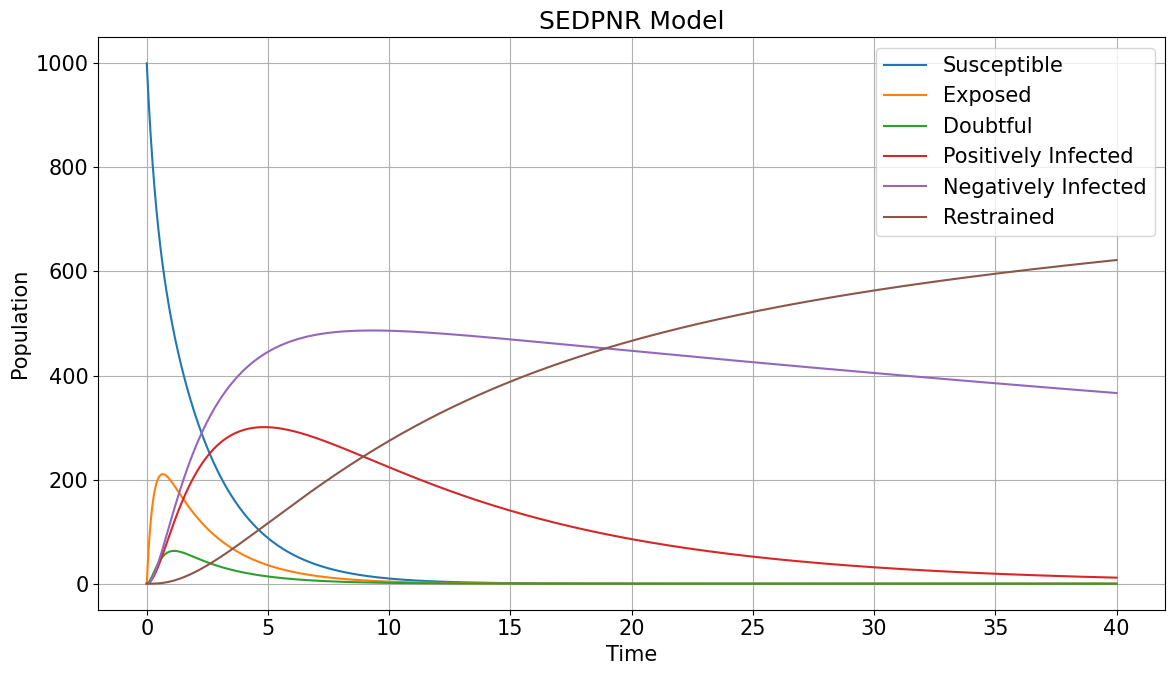

In [6]:
def SEDPNR(x,t,params = params):
    s,e,d,p,n,r = x
    mu_3 = params['beta_1'] + params['beta_2'] + params['gamma'] + params['mu_1']
    mu_4 = params['beta_3'] + params['beta_4'] + params['mu_2']

    dxdt = [params['mu_1']*e + params['mu_2']*d - params['alpha']*s, 
            params['alpha']*s - mu_3*e,
            params['gamma']*e - mu_4*d,
            params['beta_1']*e + params['beta_3']*d - params['delta_1']*p,
            params['beta_2']*e + params['beta_4']*d - params['delta_2']*n,
            params['delta_1']*p + params['delta_2']*n
            ]
    return dxdt

# Initial Condition
x0 = [1000,0.0,0.0,0.0,0.0,0.0]
t = np.linspace(0, 40, 1000)
sol = odeint(SEDPNR, x0, t)
fig, ax = plt.subplots(1,figsize = (12,7))
ax.plot(t, sol[:, 0], label='Susceptible')
ax.plot(t, sol[:, 1], label='Exposed')
ax.plot(t, sol[:, 2], label='Doubtful')
ax.plot(t, sol[:, 3], label='Positively Infected')
ax.plot(t, sol[:, 4], label='Negatively Infected')
ax.plot(t, sol[:, 5], label='Restrained')
ax.set_title(f'SEDPNR Model')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.grid()
plt.tight_layout()
plt.show()